<a target="_blank" href="https://colab.research.google.com/drive/1HVw8fpLlhfBH0AQetaEy4ObbNiOuYm6g?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 🕷️ Extract Wired Science News with Official Scrapegraph SDK

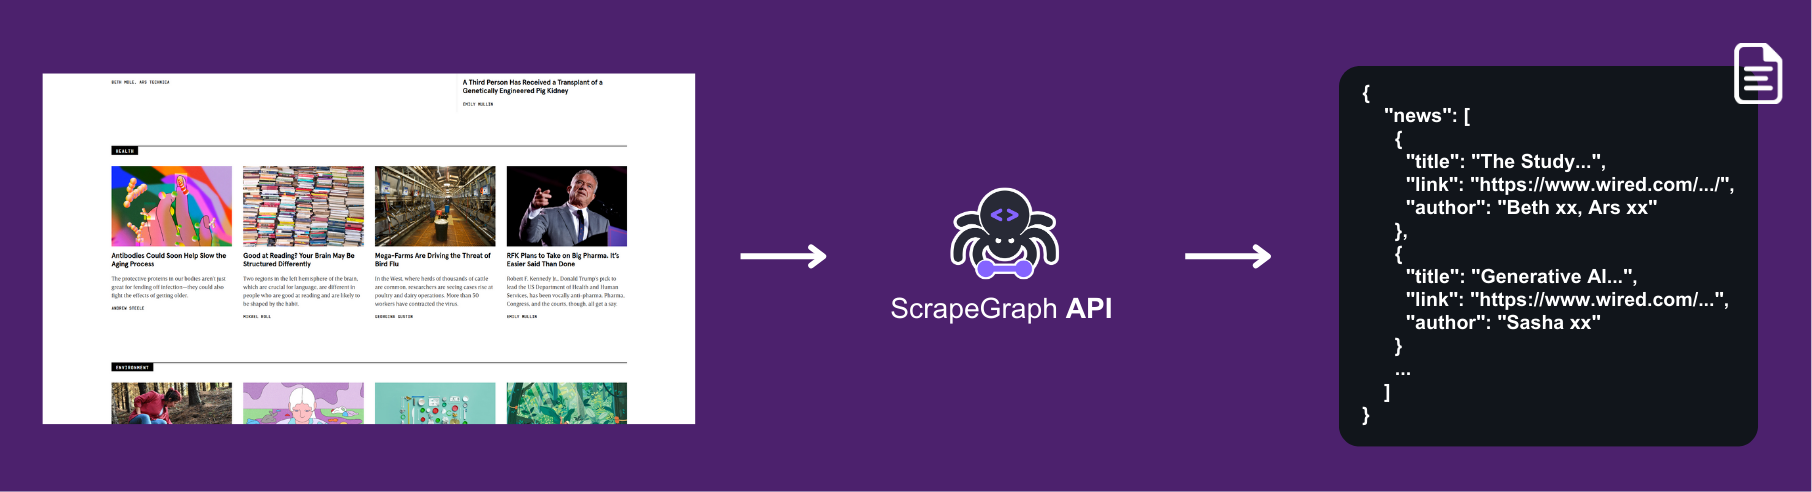

### 🔧 Install `dependencies`

In [1]:
%%capture
!pip install scrapegraph-py

### 🔑 Import `ScrapeGraph` API key

You can find the Scrapegraph API key [here](https://dashboard.scrapegraphai.com/)

In [2]:
import os
from getpass import getpass

# Check if the API key is already set in the environment
sgai_api_key = os.getenv("SGAI_API_KEY")

if sgai_api_key:
    print("SGAI_API_KEY found in environment.")
else:
    print("SGAI_API_KEY not found in environment.")
    # Prompt the user to input the API key securely (hidden input)
    sgai_api_key = getpass("Please enter your SGAI_API_KEY: ").strip()
    if sgai_api_key:
        # Set the API key in the environment
        os.environ["SGAI_API_KEY"] = sgai_api_key
        print("SGAI_API_KEY has been set in the environment.")
    else:
        print("No API key entered. Please set the API key to continue.")


SGAI_API_KEY not found in environment.
Please enter your SGAI_API_KEY: ··········
SGAI_API_KEY has been set in the environment.


### 📝 Defining an `Output Schema` for Webpage Content Extraction


If you already know what you want to extract from a webpage, you can **define an output schema** using **Pydantic**. This schema acts as a "blueprint" that tells the AI how to structure the response.

<details>
  <summary>Pydantic Schema Quick Guide</summary>

Types of Schemas  

1. Simple Schema  
Use this when you want to extract straightforward information, such as a single piece of content.  

```python
from pydantic import BaseModel, Field

# Simple schema for a single webpage
class PageInfoSchema(BaseModel):
    title: str = Field(description="The title of the webpage")
    description: str = Field(description="The description of the webpage")

# Example Output JSON after AI extraction
{
    "title": "ScrapeGraphAI: The Best Content Extraction Tool",
    "description": "ScrapeGraphAI provides powerful tools for structured content extraction from websites."
}
```

2. Complex Schema (Nested)  
If you need to extract structured information with multiple related items (like a list of repositories), you can **nest schemas**.

```python
from pydantic import BaseModel, Field
from typing import List

# Define a schema for a single repository
class RepositorySchema(BaseModel):
    name: str = Field(description="Name of the repository (e.g., 'owner/repo')")
    description: str = Field(description="Description of the repository")
    stars: int = Field(description="Star count of the repository")
    forks: int = Field(description="Fork count of the repository")
    today_stars: int = Field(description="Stars gained today")
    language: str = Field(description="Programming language used")

# Define a schema for a list of repositories
class ListRepositoriesSchema(BaseModel):
    repositories: List[RepositorySchema] = Field(description="List of GitHub trending repositories")

# Example Output JSON after AI extraction
{
    "repositories": [
        {
            "name": "google-gemini/cookbook",
            "description": "Examples and guides for using the Gemini API",
            "stars": 8036,
            "forks": 1001,
            "today_stars": 649,
            "language": "Jupyter Notebook"
        },
        {
            "name": "TEN-framework/TEN-Agent",
            "description": "TEN Agent is a conversational AI powered by TEN, integrating Gemini 2.0 Multimodal Live API, OpenAI Realtime API, RTC, and more.",
            "stars": 3224,
            "forks": 311,
            "today_stars": 361,
            "language": "Python"
        }
    ]
}
```

Key Takeaways  
- **Simple Schema**: Perfect for small, straightforward extractions.  
- **Complex Schema**: Use nesting to extract lists or structured data, like "a list of repositories."  

Both approaches give the AI a clear structure to follow, ensuring that the extracted content matches exactly what you need.
</details>


In [3]:
from pydantic import BaseModel, Field
from typing import List

# Schema for a single news item
class NewsItemSchema(BaseModel):
    category: str = Field(description="Category of the news (e.g., 'Health', 'Environment')")
    title: str = Field(description="Title of the news article")
    link: str = Field(description="URL to the news article")
    author: str = Field(description="Author of the news article")

# Schema that contains a list of news items
class ListNewsSchema(BaseModel):
    news: List[NewsItemSchema] = Field(description="List of news articles with their details")

### 🚀 Initialize `SGAI Client` and start extraction

Initialize the client for scraping (there's also an async version [here](https://github.com/ScrapeGraphAI/scrapegraph-sdk/blob/main/scrapegraph-py/examples/async_smartscraper_example.py))

In [4]:
from scrapegraph_py import Client

# Initialize the client with explicit API key
sgai_client = Client(api_key=sgai_api_key)

Here we use `Smartscraper` service to extract structured data using AI from a webpage.


> If you already have an HTML file, you can upload it and use `Localscraper` instead.





In [5]:
# Request for Trending Repositories
repo_response = sgai_client.smartscraper(
    website_url="https://www.wired.com/category/science/",
    user_prompt="Extract the first 10 news in the page",
    output_schema=ListNewsSchema,
)

Print the response

In [6]:
import json

# Print the response
request_id = repo_response['request_id']
result = repo_response['result']

print(f"Request ID: {request_id}")
print("Science News:")
print(json.dumps(result, indent=2))

Request ID: 6bf82e33-44af-4064-83c6-b447192d68da
Science News:
{
  "news": [
    {
      "category": "Science",
      "title": "The Study That Called Out Black Plastic Utensils Had a Major Math Error",
      "link": "https://www.wired.com/story/black-plastic-utensils-study-math-error-correction/",
      "author": "Beth Mole, Ars Technica"
    },
    {
      "category": "Environment",
      "title": "Generative AI and Climate Change Are on a Collision Course",
      "link": "https://www.wired.com/story/true-cost-generative-ai-data-centers-energy/",
      "author": "Sasha Luccioni"
    },
    {
      "category": "Xenotransplantation",
      "title": "A Third Person Has Received a Transplant of a Genetically Engineered Pig Kidney",
      "link": "https://www.wired.com/story/a-third-person-has-received-a-transplant-of-a-genetically-engineered-pig-kidney/",
      "author": "Emily Mullin"
    },
    {
      "category": "Health",
      "title": "Antibodies Could Soon Help Slow the Aging Proce

### 💾 Save the output to a `CSV` file

Let's create a pandas dataframe and show the table with the extracted content

In [8]:
import pandas as pd

# Convert dictionary to DataFrame
df = pd.DataFrame(result["news"])
df

,category,title,link,author
0,Science,The Study That Called Out Black Plastic Utensi...,https://www.wired.com/story/black-plastic-uten...,"Beth Mole, Ars Technica"
1,Environment,Generative AI and Climate Change Are on a Coll...,https://www.wired.com/story/true-cost-generati...,Sasha Luccioni
2,Xenotransplantation,A Third Person Has Received a Transplant of a ...,https://www.wired.com/story/a-third-person-has...,Emily Mullin
3,Health,Antibodies Could Soon Help Slow the Aging Process,https://www.wired.com/story/antibodies-could-s...,Andrew Steele
4,Science,Good at Reading? Your Brain May Be Structured ...,https://www.wired.com/story/good-at-reading-yo...,Mikael Roll
5,Health,Mega-Farms Are Driving the Threat of Bird Flu,https://www.wired.com/story/mega-farms-are-dri...,Georgina Gustin
6,Health,RFK Plans to Take on Big Pharma. It’s Easier S...,https://www.wired.com/story/rfks-plan-to-take-...,Emily Mullin
7,Environment,How Christmas Trees Could Become a Source of L...,https://www.wired.com/story/how-christmas-tree...,Alexa Phillips
8,Environment,Creating a Global Package to Solve the Problem...,https://www.wired.com/story/global-plastics-tr...,Susan Solomon
9,Environment,These 3 Things Are Standing in the Way of a Gl...,https://www.wired.com/story/these-3-things-are...,Steve Fletcher and Samuel Winton


Save it to CSV

In [9]:
# Save the DataFrame to a CSV file
csv_file = "wired_news.csv"
df.to_csv(csv_file, index=False)
print(f"Data saved to {csv_file}")

Data saved to wired_news.csv


## 🔗 Resources


<p align="left">
  <img src="https://raw.githubusercontent.com/VinciGit00/Scrapegraph-ai/main/docs/assets/api-banner.png"
       alt="ScrapeGraph API Banner" width="600">
</p>


- 🚀 **Get your API Key:** [ScrapeGraphAI Dashboard](https://dashboard.scrapegraphai.com)  
- 🐙 **GitHub:** [ScrapeGraphAI GitHub](https://github.com/scrapegraphai)  
- 💼 **LinkedIn:** [ScrapeGraphAI LinkedIn](https://www.linkedin.com/company/scrapegraphai/)  
- 🐦 **Twitter:** [ScrapeGraphAI Twitter](https://twitter.com/scrapegraphai)  
- 💬 **Discord:** [Join our Discord Community](https://discord.gg/uJN7TYcpNa)  

Made with ❤️ by the [ScrapeGraphAI](https://scrapegraphai.com) Team  
